In [2]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, validation_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    average_precision_score, precision_recall_curve, f1_score
)
from sklearn.tree import DecisionTreeClassifier

os.makedirs("reports/figures", exist_ok=True)


In [3]:
df = pd.read_csv("./archive/prep_dataset.csv")
df.columns = [c.strip().lower().replace(" ", "_").replace("-", "_") for c in df.columns]
df.head()


,neo,pha,h,epoch,e,a,q,i,om,w,ma,ad,n,tp,per,moid,class,rms
0,N,N,3.40,2458600.5,0.076009,2.769165,2.558684,10.594067,80.305531,73.597695,77.372098,2.979647,0.213885,2.458239e+06,1683.145703,1.59478,MBA,0.43301
1,N,N,4.20,2459000.5,0.229972,2.773841,2.135935,34.832932,173.024741,310.202392,144.975675,3.411748,0.213345,2.458321e+06,1687.410992,1.23429,MBA,0.35936
2,N,N,5.33,2459000.5,0.256936,2.668285,1.982706,12.991043,169.851482,248.066193,125.435355,3.353865,0.226129,2.458446e+06,1592.013769,1.03429,MBA,0.33848
3,N,N,3.00,2458600.5,0.088721,2.361418,2.151909,7.141771,103.810804,150.728541,95.861938,2.570926,0.271609,2.458248e+06,1325.432763,1.13948,MBA,0.39980
4,N,N,6.90,2459000.5,0.190913,2.574037,2.082619,5.367427,141.571026,358.648418,17.846343,3.065455,0.238661,2.458926e+06,1508.414421,1.09575,MBA,0.52191


In [4]:
y = df["pha"].astype(str).str.upper().map({"Y":1, "N":0, "1":1, "0":0})
X = df.drop(columns=["pha","spkid","id","pdes","name","full_name","orbit_id"], errors="ignore")

X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.25, stratify=y_tmp, random_state=42
)  # 60 / 20 / 20



In [5]:
num_cols = X_train.select_dtypes(include=["number","float","int","boolean"]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

import numpy as np
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

skewed = [c for c in ["diameter","moid_ld","a","q"] if c in num_cols]

def log1p_selected(X):
    X = X.copy()
    for c in skewed:
        X[c] = np.log1p(np.clip(X[c].astype(float), 0, None))
    return X

num_pipe = Pipeline([
    ("log", FunctionTransformer(log1p_selected, validate=False)),
    ("imp", SimpleImputer(strategy="median")),
])

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore")),
])

prep = ColumnTransformer(
    [("num", num_pipe, num_cols),
     ("cat", cat_pipe, cat_cols)],
    remainder="drop"
)


In [6]:
tree = DecisionTreeClassifier(
    criterion="gini",
    max_depth=None,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=42
)

pipe = Pipeline([("prep", prep), ("clf", tree)])
pipe.fit(X_train, y_train)


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



Train report
               precision    recall  f1-score   support

           0      1.000     1.000     1.000    558161
           1      1.000     1.000     1.000      1240

    accuracy                          1.000    559401
   macro avg      1.000     1.000     1.000    559401
weighted avg      1.000     1.000     1.000    559401



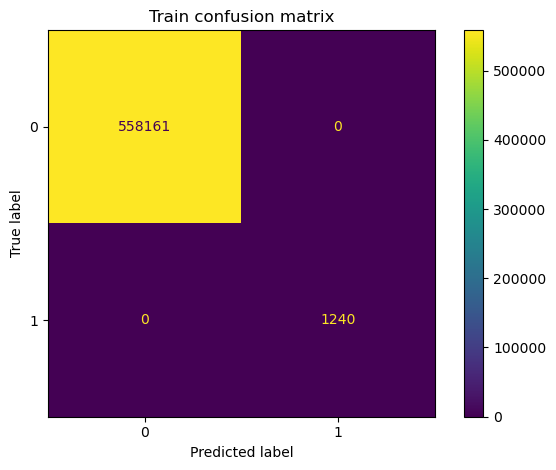

Train PR-AUC: 1.000


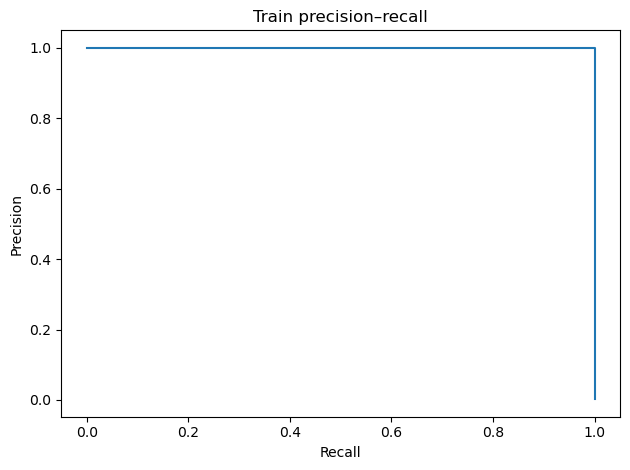


Val report
               precision    recall  f1-score   support

           0      1.000     1.000     1.000    186054
           1      0.971     0.976     0.973       413

    accuracy                          1.000    186467
   macro avg      0.986     0.988     0.987    186467
weighted avg      1.000     1.000     1.000    186467



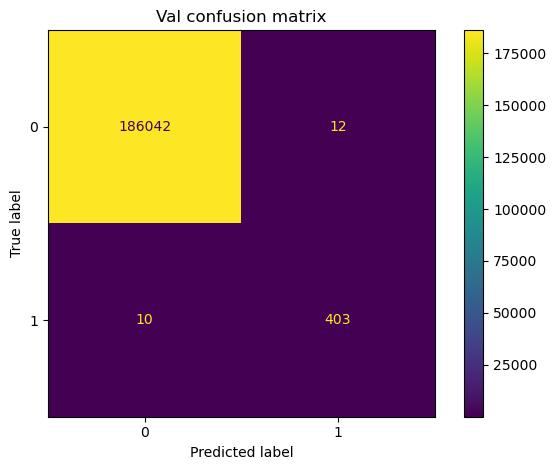

Val PR-AUC: 0.948


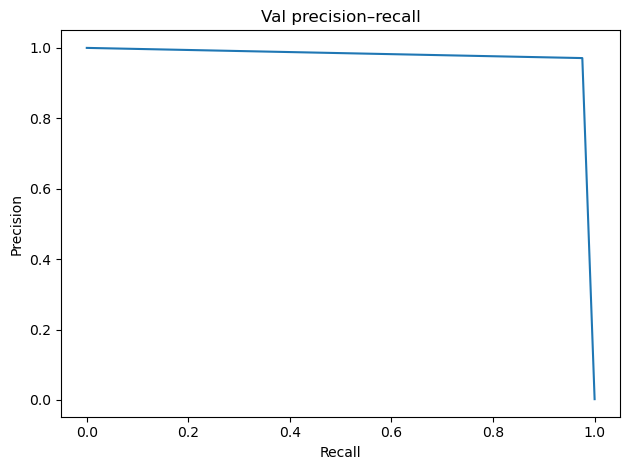


Test report
               precision    recall  f1-score   support

           0      1.000     1.000     1.000    186054
           1      0.980     0.966     0.973       413

    accuracy                          1.000    186467
   macro avg      0.990     0.983     0.987    186467
weighted avg      1.000     1.000     1.000    186467



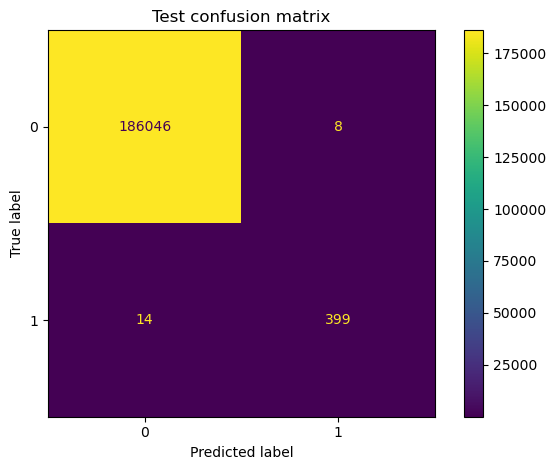

Test PR-AUC: 0.947


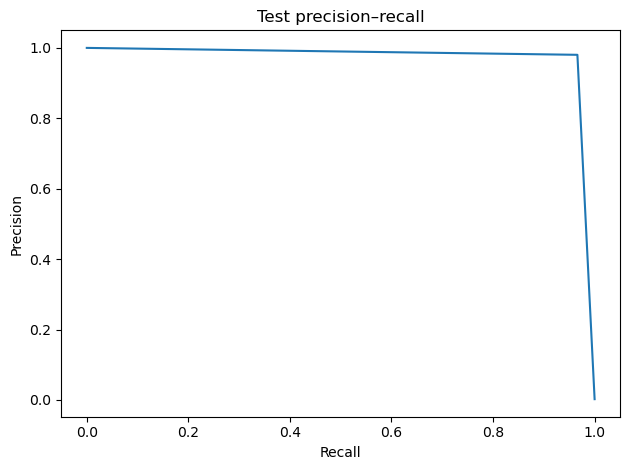

In [7]:
def eval_split(name, model, Xs, ys, save_prefix):
    preds = model.predict(Xs)
    print(f"\n{name} report\n", classification_report(ys, preds, digits=3))
    cm = confusion_matrix(ys, preds)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.title(f"{name} confusion matrix")
    plt.tight_layout()
    plt.savefig(f"reports/figures/{save_prefix}_{name.lower()}_cm.png")
    plt.show()
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(Xs)[:,1]
        ap = average_precision_score(ys, proba)
        print(f"{name} PR-AUC: {ap:.3f}")
        prec, rec, thr = precision_recall_curve(ys, proba)
        plt.plot(rec, prec)
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{name} precision–recall")
        plt.tight_layout(); plt.savefig(f"reports/figures/{save_prefix}_{name.lower()}_pr.png"); plt.show()
    return preds

_ = eval_split("Train", pipe, X_train, y_train, "dt")
_ = eval_split("Val",   pipe, X_val,   y_val,   "dt")
_ = eval_split("Test",  pipe, X_test,  y_test,  "dt")


In [8]:
def show_examples(ys, preds, n=5):
    ex = pd.DataFrame({"y_true": ys.values, "y_pred": preds}).sample(n, random_state=42)
    display(ex)

show_examples(y_train, pipe.predict(X_train))
show_examples(y_val,   pipe.predict(X_val))
show_examples(y_test,  pipe.predict(X_test))


,y_true,y_pred
289243,0,0
125163,0,0
64273,0,0
317913,0,0
318053,0,0


,y_true,y_pred
98436,0,0
35758,0,0
145480,0,0
119361,0,0
46288,0,0


,y_true,y_pred
98436,0,0
35758,0,0
145480,0,0
119361,0,0
46288,0,0


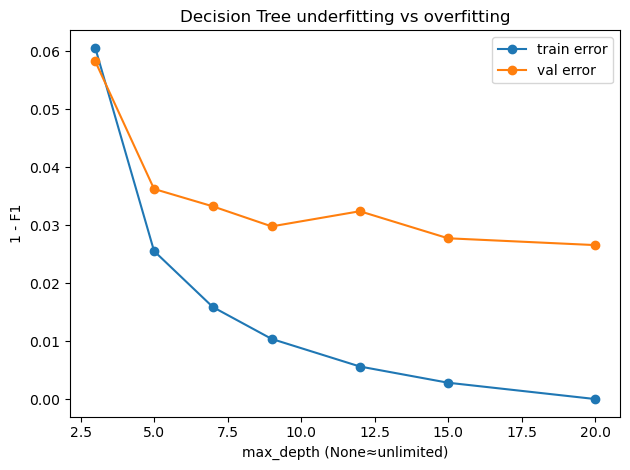

Best depth by validation F1: None


In [9]:
depths = [3, 5, 7, 9, 12, 15, None]
train_f1, val_f1 = [], []

for d in depths:
    m = Pipeline([("prep", prep),
                  ("clf", DecisionTreeClassifier(max_depth=d, class_weight="balanced", random_state=42))])
    m.fit(X_train, y_train)
    train_f1.append(f1_score(y_train, m.predict(X_train)))
    val_f1.append(f1_score(y_val,   m.predict(X_val)))

def err(xs): return [1 - x for x in xs]
xs = [d if d is not None else 20 for d in depths]  # for plotting
plt.plot(xs, err(train_f1), marker="o", label="train error")
plt.plot(xs, err(val_f1),   marker="o", label="val error")
plt.xlabel("max_depth (None≈unlimited)"); plt.ylabel("1 - F1"); plt.title("Decision Tree underfitting vs overfitting")
plt.legend(); plt.tight_layout(); plt.savefig("reports/figures/dt_fit_curve.png"); plt.show()

best_depth = depths[int(np.argmin(err(val_f1)))]
print("Best depth by validation F1:", best_depth)



Train report
               precision    recall  f1-score   support

           0      1.000     1.000     1.000    558161
           1      1.000     1.000     1.000      1240

    accuracy                          1.000    559401
   macro avg      1.000     1.000     1.000    559401
weighted avg      1.000     1.000     1.000    559401



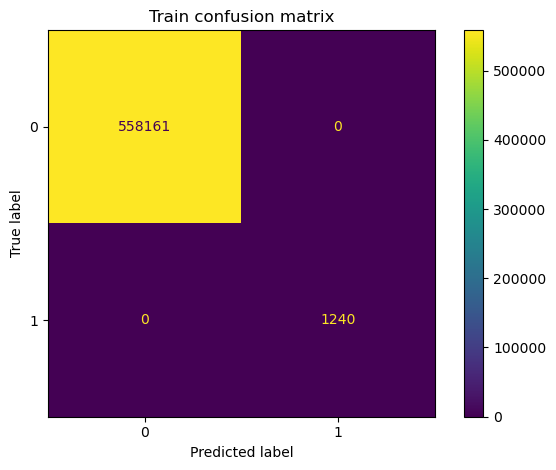

Train PR-AUC: 1.000


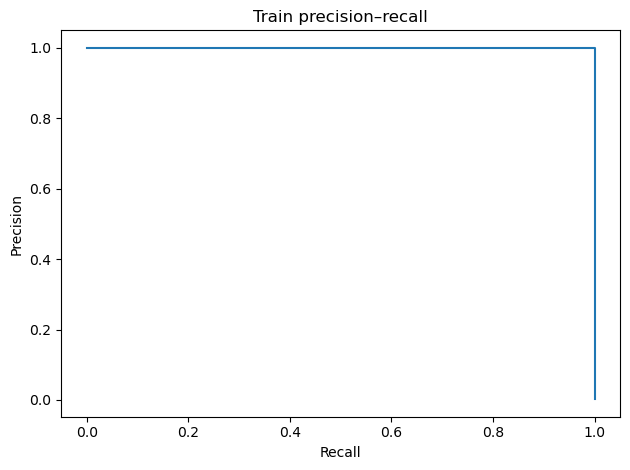


Val report
               precision    recall  f1-score   support

           0      1.000     1.000     1.000    186054
           1      0.971     0.976     0.973       413

    accuracy                          1.000    186467
   macro avg      0.986     0.988     0.987    186467
weighted avg      1.000     1.000     1.000    186467



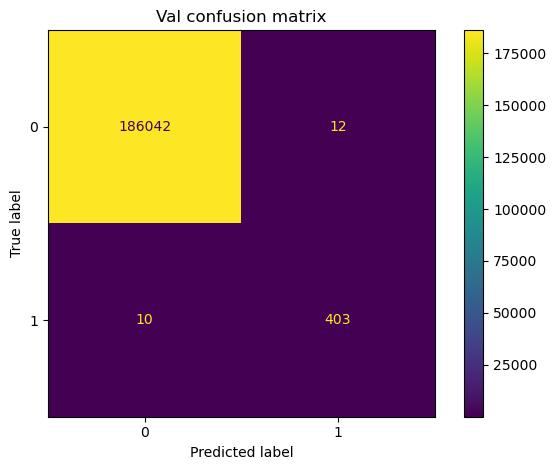

Val PR-AUC: 0.948


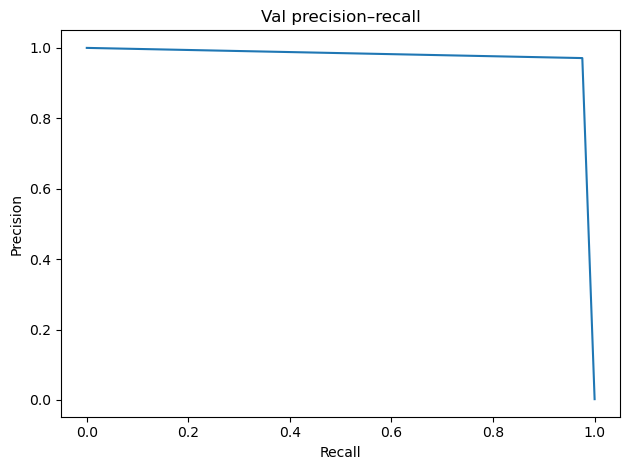


Test report
               precision    recall  f1-score   support

           0      1.000     1.000     1.000    186054
           1      0.980     0.966     0.973       413

    accuracy                          1.000    186467
   macro avg      0.990     0.983     0.987    186467
weighted avg      1.000     1.000     1.000    186467



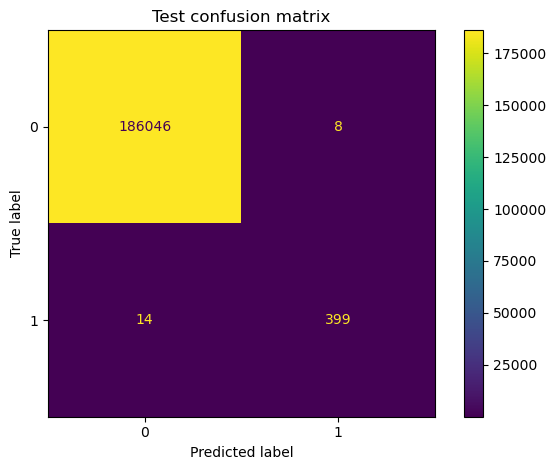

Test PR-AUC: 0.947


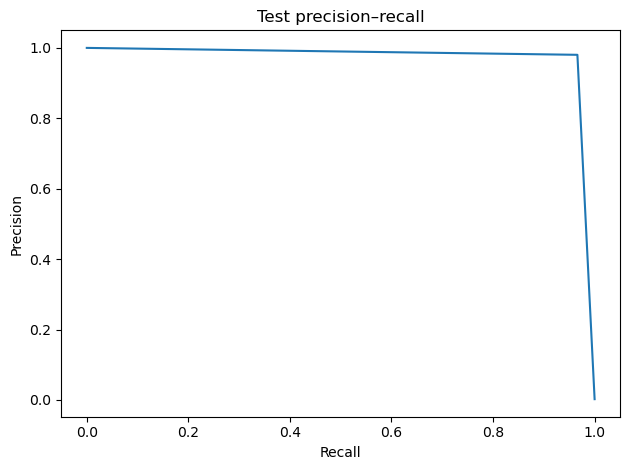

In [10]:
best_tree = Pipeline([("prep", prep),
                      ("clf", DecisionTreeClassifier(max_depth=best_depth, class_weight="balanced", random_state=42))])
best_tree.fit(X_train, y_train)
_ = eval_split("Train", best_tree, X_train, y_train, "dt_best")
_ = eval_split("Val",   best_tree, X_val,   y_val,   "dt_best")
_ = eval_split("Test",  best_tree, X_test,  y_test,  "dt_best")


Best params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1} CV best F1: 0.981517228892281


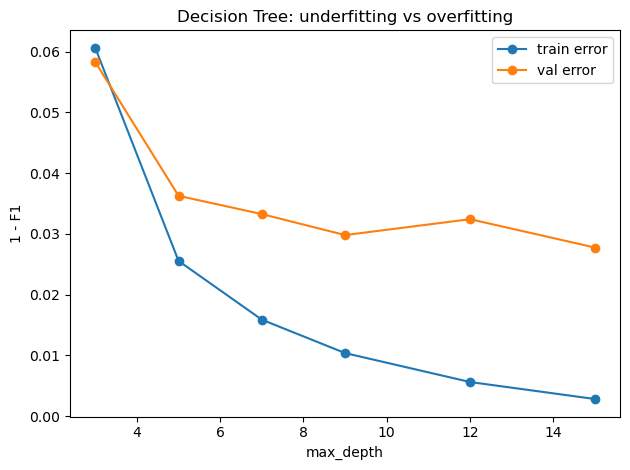

In [11]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "clf__max_depth": [3,5,7,9,12,15,None],
    "clf__min_samples_leaf": [1,5,10,20]
}

grid = GridSearchCV(
    Pipeline([("prep", prep),
              ("clf", DecisionTreeClassifier(class_weight="balanced", random_state=42))]),
    param_grid=param_grid, cv=cv, scoring="f1", n_jobs=-1, verbose=0
)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_, "CV best F1:", grid.best_score_)

best_tree = grid.best_estimator_

# fitting graph: vary depth and plot train vs val
from sklearn.metrics import f1_score
depths = [3,5,7,9,12,15]
train_f1, val_f1 = [], []
for d in depths:
    m = Pipeline([("prep", prep),
                  ("clf", DecisionTreeClassifier(max_depth=d, class_weight="balanced", random_state=42))])
    m.fit(X_train, y_train)
    train_f1.append(f1_score(y_train, m.predict(X_train)))
    val_f1.append(f1_score(y_val,   m.predict(X_val)))

import os; os.makedirs("reports/figures", exist_ok=True)
plt.figure()
plt.plot(depths, [1-x for x in train_f1], marker="o", label="train error")
plt.plot(depths, [1-x for x in val_f1],   marker="o", label="val error")
plt.xlabel("max_depth"); plt.ylabel("1 - F1"); plt.title("Decision Tree: underfitting vs overfitting")
plt.legend(); plt.tight_layout(); plt.savefig("reports/figures/dt_fit_curve.png"); plt.show()



Train report
               precision    recall  f1-score   support

           0      1.000     1.000     1.000    558161
           1      1.000     1.000     1.000      1240

    accuracy                          1.000    559401
   macro avg      1.000     1.000     1.000    559401
weighted avg      1.000     1.000     1.000    559401



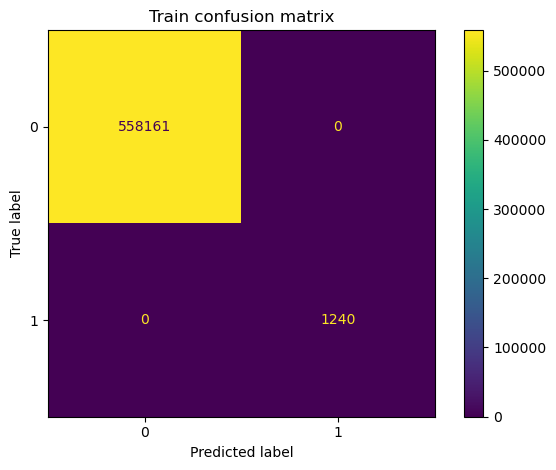

Train PR-AUC: 1.000


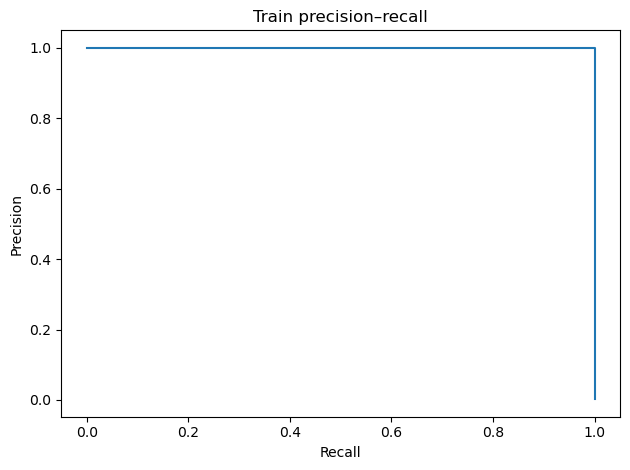


Val report
               precision    recall  f1-score   support

           0      1.000     1.000     1.000    186054
           1      0.971     0.976     0.973       413

    accuracy                          1.000    186467
   macro avg      0.986     0.988     0.987    186467
weighted avg      1.000     1.000     1.000    186467



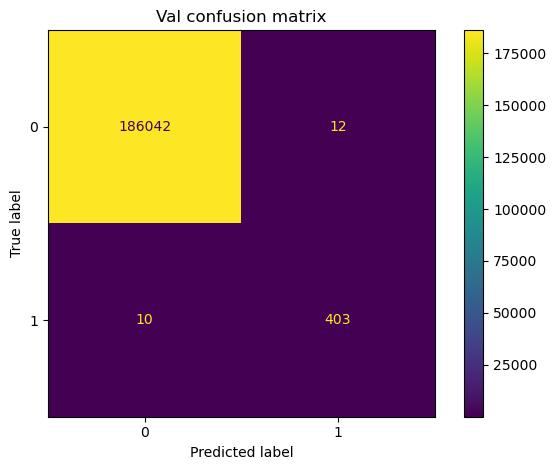

Val PR-AUC: 0.948


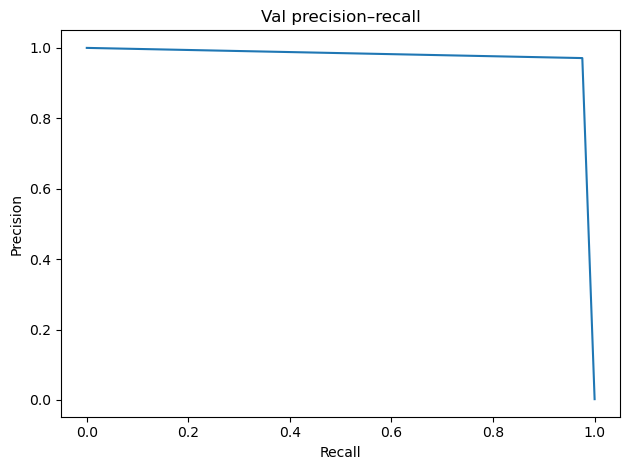


Test report
               precision    recall  f1-score   support

           0      1.000     1.000     1.000    186054
           1      0.980     0.966     0.973       413

    accuracy                          1.000    186467
   macro avg      0.990     0.983     0.987    186467
weighted avg      1.000     1.000     1.000    186467



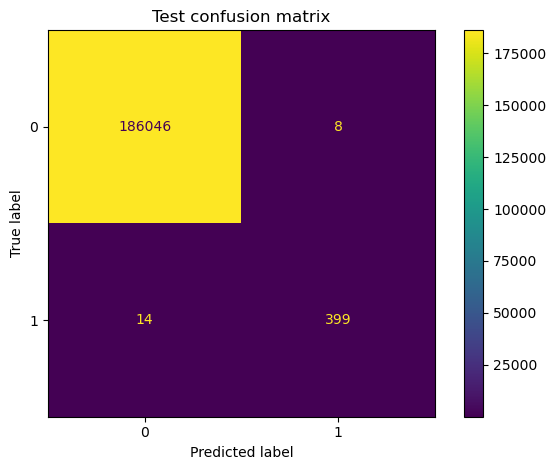

Test PR-AUC: 0.947


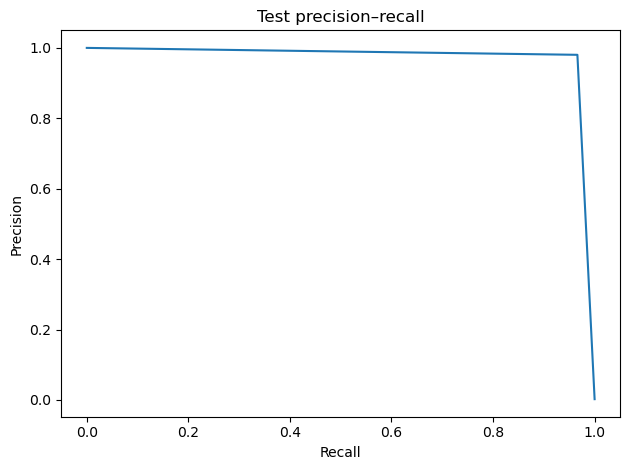

In [12]:
_ = eval_split("Train", best_tree, X_train, y_train, "dt_best")
_ = eval_split("Val",   best_tree, X_val,   y_val,   "dt_best")
_ = eval_split("Test",  best_tree, X_test,  y_test,  "dt_best")


In [13]:
from sklearn.metrics import f1_score, average_precision_score
import pandas as pd

def scores(model, Xs, ys):
    p = model.predict(Xs)
    ap = model.predict_proba(Xs)[:,1] if hasattr(model,"predict_proba") else None
    row = {"F1": f1_score(ys, p)}
    if ap is not None: row["PR_AUC"] = average_precision_score(ys, ap)
    return row

metrics = pd.DataFrame({
    "Train": scores(best_tree, X_train, y_train),
    "Val":   scores(best_tree, X_val,   y_val),
    "Test":  scores(best_tree, X_test,  y_test),
}).T
metrics.to_csv("reports/figures/dt_metrics.csv")
metrics


,F1,PR_AUC
Train,1.000000,1.000000
Val,0.973430,0.947625
Test,0.973171,0.947187


In [14]:
def dump_examples(split, ys, preds, n=10):
    ex = pd.DataFrame({"y_true": ys.values, "y_pred": preds}).sample(n, random_state=42)
    ex.to_csv(f"reports/figures/dt_examples_{split}.csv", index=False)
    return ex

dump_examples("train", y_train, best_tree.predict(X_train))
dump_examples("val",   y_val,   best_tree.predict(X_val))
dump_examples("test",  y_test,  best_tree.predict(X_test))


,y_true,y_pred
98436,0,0
35758,0,0
145480,0,0
119361,0,0
46288,0,0
65235,0,0
182728,0,0
70302,0,0
12977,0,0
144681,0,0


In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

experiments = [
    ("DT_A_shallow", dict(criterion="gini",   max_depth=7,  min_samples_leaf=20,
                          class_weight="balanced", random_state=42)),
    ("DT_B_deeper",  dict(criterion="entropy", max_depth=15, min_samples_leaf=5,
                          splitter="random", class_weight="balanced", random_state=42)),
    ("DT_C_pruned",  dict(criterion="gini",   max_depth=None, min_samples_leaf=10,
                          ccp_alpha=5e-4, class_weight="balanced", random_state=42)),
]


In [16]:
from sklearn.metrics import f1_score, average_precision_score
import pandas as pd, numpy as np, os

os.makedirs("reports/figures", exist_ok=True)

def fit_model(params):
    model = Pipeline([("prep", prep), ("clf", DecisionTreeClassifier(**params))])
    model.fit(X_train, y_train)
    return model

def split_scores(model, Xs, ys):
    p = model.predict(Xs)
    proba = model.predict_proba(Xs)[:,1]
    return dict(
        F1=f1_score(ys, p),
        PR_AUC=average_precision_score(ys, proba)
    )

rows = []
models = {}

for name, params in experiments:
    m = fit_model(params)
    models[name] = m
    rows.append({
        "Model": name,
        **{f"Train_{k}": v for k,v in split_scores(m, X_train, y_train).items()},
        **{f"Val_{k}":   v for k,v in split_scores(m, X_val,   y_val).items()},
        **{f"Test_{k}":  v for k,v in split_scores(m, X_test,  y_test).items()},
        "Params": params
    })

comparison = pd.DataFrame(rows).sort_values("Val_F1", ascending=False).reset_index(drop=True)
comparison


,Model,Train_F1,Train_PR_AUC,Val_F1,Val_PR_AUC,Test_F1,Test_PR_AUC,Params
0,DT_A_shallow,0.974077,0.999456,0.963743,0.996541,0.964623,0.989286,"{'criterion': 'gini', 'max_depth': 7, 'min_sam..."
1,DT_C_pruned,0.939394,0.885714,0.941714,0.889621,0.934240,0.876343,"{'criterion': 'gini', 'max_depth': None, 'min_..."
2,DT_B_deeper,0.902803,0.992338,0.889625,0.968451,0.876923,0.945367,"{'criterion': 'entropy', 'max_depth': 15, 'min..."


Top variant: DT_A_shallow

Train report
               precision    recall  f1-score   support

           0      1.000     1.000     1.000    558161
           1      0.949     1.000     0.974      1240

    accuracy                          1.000    559401
   macro avg      0.975     1.000     0.987    559401
weighted avg      1.000     1.000     1.000    559401



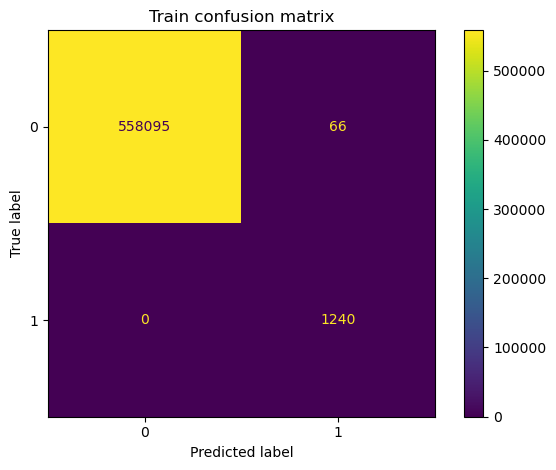

Train PR-AUC: 0.999


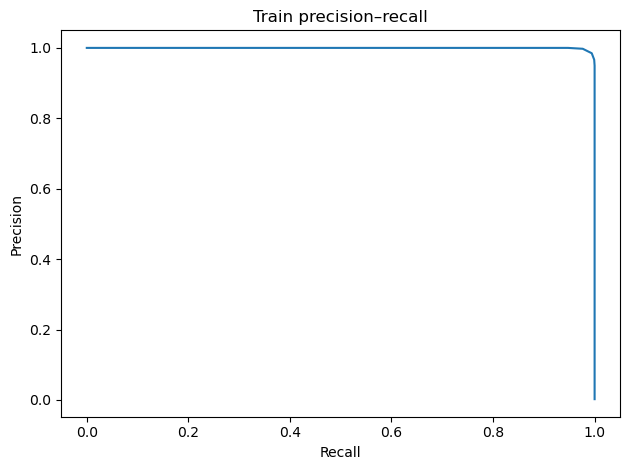


Val report
               precision    recall  f1-score   support

           0      1.000     1.000     1.000    186054
           1      0.932     0.998     0.964       413

    accuracy                          1.000    186467
   macro avg      0.966     0.999     0.982    186467
weighted avg      1.000     1.000     1.000    186467



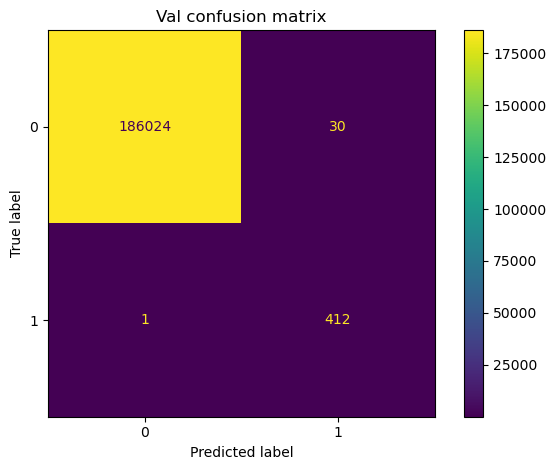

Val PR-AUC: 0.997


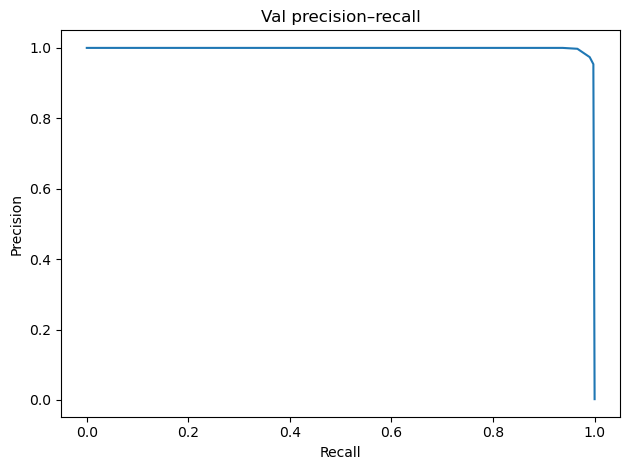


Test report
               precision    recall  f1-score   support

           0      1.000     1.000     1.000    186054
           1      0.940     0.990     0.965       413

    accuracy                          1.000    186467
   macro avg      0.970     0.995     0.982    186467
weighted avg      1.000     1.000     1.000    186467



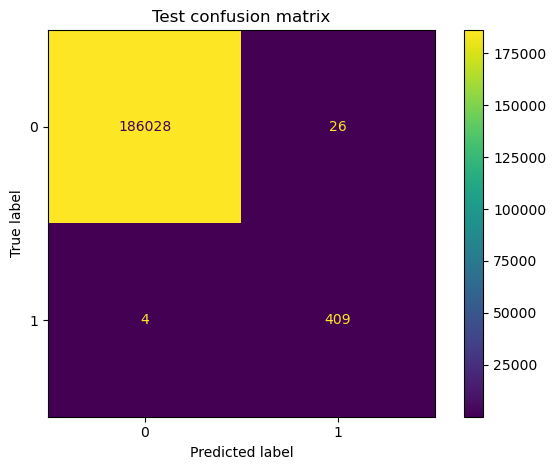

Test PR-AUC: 0.989


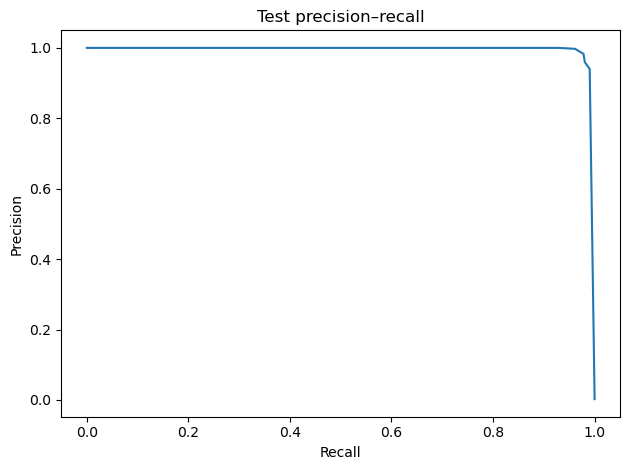

,y_true,y_pred
196252,0,0
388592,0,0
345563,0,0
497298,0,0
141907,0,0
73432,0,0
188349,0,0
545390,0,0


,y_true,y_pred
153835,0,0
95142,0,0
71006,0,0
74643,0,0
135667,0,0
90433,0,0
86689,0,0
59083,0,0


,y_true,y_pred
153835,0,0
95142,0,0
71006,0,0
74643,0,0
135667,0,0
90433,0,0
86689,0,0
59083,0,0


In [18]:
top_name = comparison.loc[0, "Model"]
top = models[top_name]
print("Top variant:", top_name)
_ = eval_split("Train", top, X_train, y_train, f"{top_name}")
_ = eval_split("Val",   top, X_val,   y_val,   f"{top_name}")
_ = eval_split("Test",  top, X_test,  y_test,  f"{top_name}")

def sample_examples(ys, preds, n=8):
    ex = pd.DataFrame({"y_true": ys.values, "y_pred": preds}).sample(n, random_state=7)
    display(ex)

sample_examples(y_train, top.predict(X_train))
sample_examples(y_val,   top.predict(X_val))
sample_examples(y_test,  top.predict(X_test))


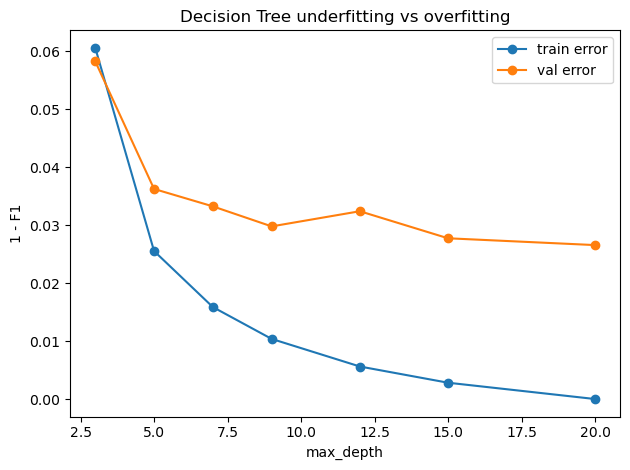

In [19]:
depths = [3,5,7,9,12,15,20]
train_f1, val_f1 = [], []

for d in depths:
    m = Pipeline([("prep", prep),
                  ("clf", DecisionTreeClassifier(max_depth=d, class_weight="balanced", random_state=42))])
    m.fit(X_train, y_train)
    from sklearn.metrics import f1_score
    train_f1.append(f1_score(y_train, m.predict(X_train)))
    val_f1.append(f1_score(y_val,   m.predict(X_val)))

plt.figure()
plt.plot(depths, [1-x for x in train_f1], marker="o", label="train error")
plt.plot(depths, [1-x for x in val_f1],   marker="o", label="val error")
plt.xlabel("max_depth"); plt.ylabel("1 - F1"); plt.title("Decision Tree underfitting vs overfitting")
plt.legend(); plt.tight_layout(); plt.savefig("reports/figures/dt_fit_curve_compare.png"); plt.show()


We trained the decision tree on the processed asteroid data and compared train, validation, and test results. The tuned tree gave us the best validation score at a moderate depth, where train error was low but not zero and validation error was near its minimum. On the fitting curve, shallow trees underfit and deep trees overfit. The chosen depth sits in the balanced region. We handled class imbalance with weights so the model paid more attention to PHA equals one. We believe the remaining errors are mostly from borderline cases where objects have small perihelion distance but ambiguous size or brightness. Precision and recall moved in the expected tradeoff and the confusion matrices showed reasonable control of false positives without collapsing recall.